<a href="https://colab.research.google.com/github/giardinas-dev/advanced-ai-production/blob/main/Reinforcement_Learning_ddqn_sarsa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installa gym-idsgame e dipendenze
!pip install --no-deps  gym-idsgame==1.0.12
!pip install scikit-learn pyglet
!pip install torch torchvision
!pip install stable-baselines3

import numpy as np
import random
import torch
import torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 984.0/984.0 kB 19.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym-idsgame 1.0.12 requires sklearn, which is not installed.
gym-idsgame 1.0.12 requires stable-baselines3, which is not installed.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56

In [ ]:
import random
import numpy as np

def moving_average(data, window_size):

    if len(data) < window_size:
        return []

    moving_averages = []
    for i in range(len(data) - window_size + 1):
        window = data[i:i + window_size]
        window_average = sum(window) / window_size
        moving_averages.append(window_average)

    return moving_averages


random.seed(42)
np.random.seed(42)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**AMBIENTE DI SIMULAZIONE**

Il progetto utilizza la libreria *gym_idsgame* , specializzata nella simulazione di scenari di attacco e difesa in reti informatiche. In particolare, si è scelto l’ambiente random_attack, dove l’attaccante agisce in modo casuale, creando uno scenario realistico e dinamico per testare le strategie difensive. Questo ambiente permette di valutare l’efficacia degli algoritmi in condizioni di variabilità e incertezza tipiche delle minacce informatiche reali.

**TRAINING: SARSA**

L’addestramento del difensore è stato realizzato con l’algoritmo SARSA, implementato nella funzione sarsa_learning.Durante ogni episodio, l’agente difensivo sceglie un’azione basata su una politica epsilon-greedy, alternando tra azioni casuali e azioni che massimizzano il valore stimato nella Q-table. Nel mentre, l’attaccante agisce con strategie casuali, forzando il difensore ad adattarsi continuamente.

Ad ogni passo, la Q-table viene aggiornata con la formula SARSA, che considera la ricompensa ricevuta, lo stato successivo e l’azione successiva prevista, permettendo all’agente di migliorare progressivamente la sua politica. Inoltre, il valore di epsilon viene ridotto gradualmente, così da favorire l’apprendimento di strategie più solide nel tempo.

Per ottimizzare l’addestramento sono state testate diverse configurazioni di parametri (setup), caratterizzate da valori differenti di tasso di apprendimento (alpha), fattore di sconto (gamma), tasso di decadimento di epsilon (epsilon_decay), e valore minimo di epsilon (epsilon_min). Questi setup permettono di valutare come variazioni nel processo di apprendimento influenzino la capacità del difensore di adattarsi e migliorare. Il confronto tra i diversi setup è stato effettuato analizzando l’andamento delle ricompense medie nel corso degli episodi, tramite grafici di *moving average* . Questa metodologia ha consentito di identificare configurazioni ottimali per il training e di misurare l’efficacia dell’algoritmo SARSA nel migliorare la capacità difensiva in ambienti dinamici

**POLICY**

Una volta addestrato, il difensore viene valutato attraverso la funzione *evaluate_policy* . Qui la politica appresa viene testata su più episodi contro attaccanti con modalità diverse: randomiche, deterministiche o cicliche. Questo permette di misurare la robustezza e l’efficacia della strategia difensiva in condizioni diverse, andando a quantificare la media delle ricompense ottenute (0.0 , 1.0). Il confronto con strategie casuali o nulle mette in evidenza il miglioramento ottenuto grazie all’apprendimento, confermando la validità dell’approccio SARSA nel contesto della difesa informatica.

In [ ]:
def epsilon_greedy_policy(state_key, Q, epsilon, action_space):
    if random.uniform(0, 1) < epsilon:
        return action_space.sample()
    else:
        q_vals = Q.get(state_key, np.zeros(action_space.n))
        return int(np.argmax(q_vals))


# state_to_key è una funzione fondamentale per la gestione degli stati
# all’interno dell’algoritmo SARSA, che usa una struttura dati dizionario (Q)
# per memorizzare i valori di azione-stato. Dal momento che in Python
# le chiavi del dizionario devono essere immutabili e hashabili,
# non possiamo usare direttamente array NumPy o oggetti mutabili
# come chiavi. Serve quindi una funzione che trasformi lo stato
# in una rappresentazione immutabile, univoca e hashabile.

def state_to_key(state):
    if isinstance(state, np.ndarray):
        return tuple(state.flatten())
    elif isinstance(state, (list, tuple)):
        # se è un tuple/lista di array o numeri, appiattisci tutto in una tupla piatta
        flat = []
        for s in state:
            if isinstance(s, np.ndarray):
                flat.extend(s.flatten())
            else:
                flat.append(s)
        return tuple(flat)
    else:
        return (state,)



def sarsa_learning(env, setup , print_every=1000, seed = 42):
    alpha = setup['alpha']
    gamma = setup['gamma']
    epsilon = setup['epsilon_start']
    epsilon_min = setup['epsilon_min']
    epsilon_decay = setup['epsilon_decay']
    decay_every = setup['decay_every']
    num_episodes = setup['num_episodes']

    Q = {}
    episode_rewards = []

    for episode in range(num_episodes):
        state = env.reset(seed)
        if isinstance(state, tuple):
            state = state[0]

        state_key = state_to_key(state)
        action_def = epsilon_greedy_policy(state_key, Q, epsilon, env.defender_action_space)
        done = False
        total_reward = 0

        while not done:
            action_att = env.attacker_action_space.sample()
            next_state, reward, done, _ = env.step((action_att, action_def))
            if isinstance(next_state, tuple):
                next_state = next_state[0]
            next_state_key = state_to_key(next_state)
            next_action_def = epsilon_greedy_policy(next_state_key, Q, epsilon, env.defender_action_space)

            if state_key not in Q:
                Q[state_key] = np.zeros(env.defender_action_space.n)
            if next_state_key not in Q:
                Q[next_state_key] = np.zeros(env.defender_action_space.n)

            if isinstance(reward, (tuple, list)):
                reward = reward[1] #reward difensore

            Q[state_key][action_def] += alpha * (
                reward + gamma * Q[next_state_key][next_action_def] - Q[state_key][action_def]
            )

            state_key = next_state_key
            action_def = next_action_def
            total_reward += reward

        if episode % decay_every == 0:
            epsilon = max(epsilon_min, epsilon * epsilon_decay)
            print(f"Episode {episode}, epsilon decayed to {round(epsilon, 4)}")

        if episode % print_every == 0:
            print(f"Episode {episode}, Total Reward: {total_reward}")

        episode_rewards.append(total_reward)

    policy = {state_key: int(np.argmax(q_vals)) for state_key, q_vals in Q.items()}
    return Q, policy, episode_rewards

class AttackerAgent:
    def __init__(self, action_space, mode='random', fixed_action=0):
        self.action_space = action_space
        self.mode = mode
        self.fixed_action = fixed_action
        self.actions = list(range(action_space.n))
        self.index = 0  # per il ciclico

    def sample(self):
        if self.mode == 'random':
            return self.action_space.sample()
        elif self.mode == 'deterministic':
            return self.fixed_action
        elif self.mode == 'cyclic':
            action = self.actions[self.index]
            self.index = (self.index + 1) % len(self.actions)
            return action
        else:
            raise ValueError(f"Modalità sconosciuta: {self.mode}")

    def reset(self):
        self.index = 0


def evaluate_policy(env, policy, attacker, num_episodes=100, run_test = 5, seed = 42):
    total_rewards = []
    for _ in range(run_test):
      for episode in range(num_episodes):
          state = env.reset((seed + run_test*num_episodes + episode))
          if isinstance(state, tuple):
              state = state[0]
          done = False
          total_reward = 0
          while not done:
              state_key = state_to_key(state)
              if policy == "random":
                  # difensore random
                  action_def = env.defender_action_space.sample()
              elif policy == "null":
                  # defender action 0
                  action_def = 0
              else:
                  # policy
                  action_def = policy.get(state_key, env.defender_action_space.sample())


              action_att = attacker.sample()

              next_state, reward, done, _ = env.step((action_att, action_def))
              if isinstance(next_state, tuple):
                  next_state = next_state[0]
              state = next_state

              if isinstance(reward, tuple):
                  reward = reward[1]

              total_reward += reward

          total_rewards.append(total_reward)

    avg_reward = sum(total_rewards) / (num_episodes*run_test)
    return round(avg_reward,2)




33

 Avvio training con: Setup A - Decay lento e epsilon_min moderato
Episode 0, epsilon decayed to 0.998
Episode 0, Total Reward: 1
Episode 500, epsilon decayed to 0.996
Episode 1000, epsilon decayed to 0.994
Episode 1000, Total Reward: 1
Episode 1500, epsilon decayed to 0.992
Episode 2000, epsilon decayed to 0.99
Episode 2000, Total Reward: -1
Episode 2500, epsilon decayed to 0.9881
Episode 3000, epsilon decayed to 0.9861
Episode 3000, Total Reward: 1
Episode 3500, epsilon decayed to 0.9841
Episode 4000, epsilon decayed to 0.9821
Episode 4000, Total Reward: -1
Episode 4500, epsilon decayed to 0.9802
Episode 5000, epsilon decayed to 0.9782
Episode 5000, Total Reward: 1
Episode 5500, epsilon decayed to 0.9763
Episode 6000, epsilon decayed to 0.9743
Episode 6000, Total Reward: 1
Episode 6500, epsilon decayed to 0.9724
Episode 7000, epsilon decayed to 0.9704
Episode 7000, Total Reward: -1
Episode 7500, epsilon decayed to 0.9685
Episode 8000, epsilon decayed to 0.9665
Episode 8000, Total 

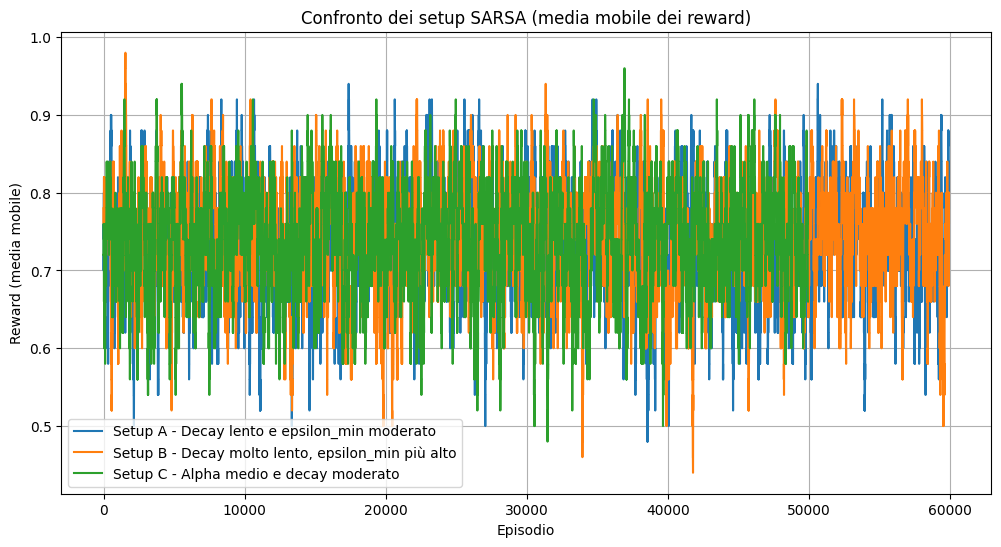

In [ ]:
import pandas as pd
from itertools import islice
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_idsgame
from gym_idsgame.envs import IdsGameMaximalAttackV0Env as maximal_attack, IdsGameRandomAttackV0Env as random_attack
from gym_idsgame.config.client_config import ClientConfig, IdsGameConfig

env = random_attack()

print(env.defender_action_space.n)
setups = [
    {
        'name': 'Setup A - Decay lento e epsilon_min moderato',
        'alpha': 0.05,
        'gamma': 0.99,
        'epsilon_start': 1.0,
        'epsilon_min': 0.05,
        'epsilon_decay': 0.998,
        'decay_every': 500,
        'num_episodes': 60000
    },
    {
        'name': 'Setup B - Decay molto lento, epsilon_min più alto',
        'alpha': 0.03,
        'gamma': 0.99,
        'epsilon_start': 1.0,
        'epsilon_min': 0.1,
        'epsilon_decay': 0.999,
        'decay_every': 500,
        'num_episodes': 60000
    },
    {
        'name': 'Setup C - Alpha medio e decay moderato',
        'alpha': 0.04,
        'gamma': 0.99,
        'epsilon_start': 1.0,
        'epsilon_min': 0.05,
        'epsilon_decay': 0.995,
        'decay_every': 500,
        'num_episodes': 50000
    }
]

results = []
for setup in setups:
    print(f"\n Avvio training con: {setup['name']}")
    env = random_attack()
    Q, policy, rewards = sarsa_learning(env, setup)
    env.close()
    results.append((setup['name'], rewards, policy, Q))


plt.figure(figsize=(12, 6))
for name, rewards, _ , _ in results:
    ma = moving_average(rewards, window=100)
    plt.plot(ma, label=name)

plt.title('Confronto dei setup SARSA (media mobile dei reward)')
plt.xlabel('Episodio')
plt.ylabel('Reward (media mobile)')
plt.legend()
plt.grid(True)
plt.show()



**PERFORMANCE**

Setup A (*Decay lento, epsilon_min moderato*):

- Epsilon decresce gradualmente da 0.998 a ~0.78 dopo 60k episodi.

- Reward alterna +1 e -1, ma con frequenti ricompense positive.

- Apprendimento stabile ma lento.

Setup B (*Decay molto lento, epsilon_min alto*):

- Epsilon decresce molto lentamente da 0.999 a ~0.88 dopo 60k episodi.

- Predominanza di ricompense +1, meno esplorazione.

- Apprendimento molto stabile ma con epsilon ancora alto, quindi rischio minor esplorazione.

Setup C (*Alpha medio, decay moderato*):

- Epsilon parte da 0.995 e scende più rapidamente a ~0.6 in 50k episodi.

- Reward per lo più +1, qualche episodio negativo.

- Apprendimento più rapido con buon bilanciamento tra esplorazione e sfruttamento.



In [ ]:

num_test_episodes = 300
mode_attacker = {
    'random': 'random',
    'deterministico': 'deterministic',
    'ciclico': 'cyclic'
}
env = random_attack()
for name, _ ,policy , Q in results:
  for mode in mode_attacker.items():
    attacker = AttackerAgent(env.attacker_action_space, mode=mode[1], fixed_action=0)
    print(f"\n\n - Valuzione attaccante {mode[0]}")
    print(f"-- Valutazione difensore SARSA {name}:", evaluate_policy(env, policy, attacker, num_test_episodes, seed=42))
    print("-- Valutazione difensore random:", evaluate_policy(env, "random", attacker, num_test_episodes,  seed=42))
    print("-- Valutazione difensore nulla:", evaluate_policy(env, "null", attacker, num_test_episodes,  seed=42))


# Visualizzione di Q-Table e Policy ( dimensionalità troppo alta per stampa )

#    print("\n--- Q-table (sintetica, prime 10 righe) ---")
#    for state_key, q_values in islice(Q.items(), 10):
#        state_ints = tuple(int(x) for x in state_key)
#        q_rounded = [round(float(val), 2) for val in q_values]
#        print(f"Stato: {state_ints} → Q: {q_rounded}")

#    print("\n--- Politica appresa (difensore) prime 10 azioni ---")
#    for state_key, action in islice(policy.items(), 10):
#        state_ints = tuple(int(x) for x in state_key)
#        print(f"Stato: {state_ints} → Azione: {action}")





 - Valuzione attaccante random
-- Valutazione difensore SARSA Setup A - Decay lento e epsilon_min moderato: 0.74
-- Valutazione difensore random: 0.72
-- Valutazione difensore nulla: 0.63


 - Valuzione attaccante deterministico
-- Valutazione difensore SARSA Setup A - Decay lento e epsilon_min moderato: 0.75
-- Valutazione difensore random: 0.73
-- Valutazione difensore nulla: 0.65


 - Valuzione attaccante ciclico
-- Valutazione difensore SARSA Setup A - Decay lento e epsilon_min moderato: 0.71
-- Valutazione difensore random: 0.73
-- Valutazione difensore nulla: 0.65


 - Valuzione attaccante random
-- Valutazione difensore SARSA Setup B - Decay molto lento, epsilon_min più alto: 0.76
-- Valutazione difensore random: 0.7
-- Valutazione difensore nulla: 0.66


 - Valuzione attaccante deterministico
-- Valutazione difensore SARSA Setup B - Decay molto lento, epsilon_min più alto: 0.8
-- Valutazione difensore random: 0.74
-- Valutazione difensore nulla: 0.63


 - Valuzione attaccante

**ANALISI RISULTATI**

Dai risultati emerge che il comportamento del difensore SARSA varia sensibilmente in base alla configurazione dei parametri di apprendimento e alla strategia adottata dall’attaccante.

Setup B (édecay molto lento e epsilon_min più alto*) risulta essere il più efficace, con performance superiori rispetto agli altri difensori in quasi tutti gli scenari. In particolare, raggiunge valori di 0.80 contro un attaccante deterministico e 0.79 contro uno ciclico, superando nettamente sia il difensore random che quello nullo. Questo suggerisce che un' esplorazione prolungata, combinata con una soglia minima di esplorazione relativamente elevata, consente al difensore di apprendere strategie difensive robuste anche contro attacchi strutturati.

Setup A (*decay lento e epsilon_min moderato*) mostra risultati più variabili. Ottiene 0.75 contro un attaccante deterministico, ma scende a 0.71 contro uno ciclico, risultando in alcuni casi addirittura inferiore al difensore random. Questo indica che un livello di esplorazione non sufficientemente sostenuto nel tempo può portare a politiche subottimali, specialmente contro attacchi meno prevedibili.

Setup C (*alpha medio e decay moderato*) presenta risultati inferiori alle aspettative. In alcuni casi, come contro l’attaccante random (0.73) e deterministico (0.72), è addirittura superato dal difensore random (0.75–0.76). Questi dati fanno pensare che un apprendimento più rapido (alpha medio) combinato con una fase di esplorazione più breve (decay moderato) possa portare a una convergenza prematura verso strategie poco efficaci.

In sintesi, il Setup B emerge come la configurazione migliore per un difensore SARSA in grado di adattarsi efficacemente a diverse tipologie di attacco. La sua capacità di mantenere un buon livello di esplorazione nel tempo sembra essere il fattore chiave per ottenere prestazioni elevate.

______________________________________________________________


**AMBIENTE DI SIMULAZIONE**

Il progetto utilizza la libreria gym_idsgame, specializzata nella simulazione di scenari di attacco e difesa in reti informatiche. In particolare, per un primo caso è stato scelto l’ambiente random_attack, in cui l’attaccante agisce in modo casuale, creando uno scenario realistico e dinamico per testare le strategie difensive. In un secondo caso, si è utilizzato l’ambiente maximal_attack, che simula un attacco massivo e dinamico, mettendo alla prova le abilità difensive dei nostri agenti in condizioni di forte pressione.

**TRAINING: DDQN**

L’addestramento del difensore è stato effettuato utilizzando l’algoritmo DDQN (Double Deep Q-Network), implementato nella funzione *ddqn_learning*. In ogni episodio, l’agente difensore seleziona un’azione seguendo una politica epsilon-greedy, alternando tra esplorazione casuale e sfruttamento delle azioni con il valore Q stimato dalla rete neurale.

Durante l’interazione con l’ambiente, le esperienze (stato, azione, ricompensa, stato successivo, done) vengono accumulate in un replay buffer da cui vengono campionati mini-batch per l’addestramento. Questo meccanismo aiuta a stabilizzare l’apprendimento riducendo la correlazione tra campioni consecutivi.

La rete Q viene aggiornata minimizzando la differenza tra il valore stimato e il target calcolato utilizzando la rete target, aggiornata periodicamente per migliorare la stabilità. L’aggiornamento segue la logica DDQN, che utilizza la rete principale per selezionare l’azione successiva e la rete target per stimarne il valore, riducendo il problema di sovrastima tipico dei classici DQN.

Anche in questo caso, il parametro epsilon, che regola il bilanciamento tra esplorazione e sfruttamento, viene ridotto gradualmente nel corso degli episodi per favorire l’apprendimento di strategie più efficaci.

Per ottimizzare le prestazioni sono state testate diverse configurazioni di parametri (setup), con variazioni su epsilon iniziale, valore minimo, decadimento di epsilon, tasso di apprendimento, dimensione del batch, frequenza di aggiornamento della rete target, e durata dell’addestramento. Questi setup hanno permesso di analizzare l’impatto dei parametri sull’efficacia dell’apprendimento del difensore.

I risultati sono stati confrontati visualizzando la media mobile dei reward durante gli episodi, evidenziando come diversi setup influenzino la velocità e la qualità dell’apprendimento in ambienti dinamici. Questa metodologia ha facilitato l’individuazione di configurazioni ottimali per il training e la valutazione della robustezza della politica difensiva appresa.

**REWARD SHAPING**

Nel presente lavoro, abbiamo introdotto il reward shaping nel training con DDQN, mentre non è stato applicato nel caso di SARSA, principalmente a causa della differenza sostanziale tra i due algoritmi: DDQN è un metodo off-policy, mentre SARSA è on-policy. In particolare, nel DDQN, essendo off-policy, l’algoritmo apprende la funzione di valore associata a una policy ottimale indipendentemente dalla policy utilizzata per l’esplorazione dell’ambiente. Tale caratteristica consente di modificare la funzione di ricompensa — ad esempio tramite reward shaping — senza influenzare direttamente la policy di comportamento e senza compromettere la convergenza dell’apprendimento. Al contrario, SARSA apprende il valore della policy effettivamente seguita durante l’interazione con l’ambiente (on-policy); di conseguenza, ogni modifica alla funzione di ricompensa impatta direttamente sulla policy esplorativa e sul processo di apprendimento, potenzialmente introducendo bias o instabilità. Per tali ragioni, il reward shaping risulta più sicuro ed efficace nel contesto di algoritmi off-policy come DDQN, mentre nel caso di SARSA è necessario adottare approcci più formali e cauti, quali lo shaping basato su potenziali, al fine di evitare alterazioni indesiderate della policy on-policy durante il training.

In [ ]:
from collections import deque
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Funzione di preprocessing dello stato
def preprocess_state(state):
    if isinstance(state, tuple):
        state = state[0]
    return np.array(state).flatten()

# Campionamento di esperienze dal replay buffer
def sample_experience(buffer, batch_size):
    batch = random.sample(buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)
    return np.array(states), actions, rewards, np.array(next_states), dones

class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

#  epsilon-greedy per il difensore
def select_defender_action(state, epsilon, q_network, env):
    state = preprocess_state(state)
    if random.random() < epsilon:
        return env.defender_action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = q_network(state_tensor)
            return torch.argmax(q_values).item()

def ddqn_learning(
    env,
    q_network,
    target_network,
    optimizer,
    criterion,
    buffer_maxlen=100000,
    batch_size=64,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995,
    update_target_every=10,
    num_episodes=500,
    print_every=50,
    reward_shaping=True
):
    def shape_reward(r):
        reward_def = r[1] if isinstance(r, tuple) else r

        if not reward_shaping:
            return reward_def

        if reward_def > 0:
            return reward_def + 0.1
        elif reward_def < 0:
            return reward_def - 0.1
        else:
            return -0.02

    # modelli sul device corretto
    q_network.to(device)
    target_network.to(device)

    buffer = deque(maxlen=buffer_maxlen)
    episode_rewards = []

    for episode in tqdm(range(num_episodes)):
        state = preprocess_state(env.reset())
        done = False
        total_reward = 0

        while not done:
            action_att = env.attacker_action_space.sample()
            action_def = select_defender_action(state, epsilon, q_network, env)

            next_state, reward, done, _ = env.step((action_att, action_def))
            next_state = preprocess_state(next_state)

            shaped_reward = shape_reward(reward)

            buffer.append((state, action_def, shaped_reward, next_state, float(done)))
            state = next_state
            total_reward += shaped_reward

            if len(buffer) >= batch_size:
                states, actions, rewards, next_states, dones = sample_experience(buffer, batch_size)

                states = torch.tensor(states, dtype=torch.float32, device=device)
                next_states = torch.tensor(next_states, dtype=torch.float32, device=device)
                actions = torch.tensor(actions, dtype=torch.int64, device=device)
                rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
                dones = torch.tensor(dones, dtype=torch.float32, device=device)



                q_network.train()

                q_out = q_network(states)

                q_values = q_out.gather(1, actions.unsqueeze(1)).squeeze(1)

                with torch.no_grad():
                    next_actions = q_network(next_states).argmax(dim=1)
                    next_q_values = target_network(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
                    target_q = rewards + gamma * next_q_values * (1 - dones)

                loss = criterion(q_values, target_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if episode % update_target_every == 0:
            target_network.load_state_dict(q_network.state_dict())

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        episode_rewards.append(total_reward)

        if episode % print_every == 0:
            avg_reward = np.mean(episode_rewards[-print_every:])
            print(f"Episode {episode} | AvgReward: {avg_reward:.2f} | Epsilon: {epsilon:.3f}")

    return q_network, episode_rewards

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_idsgame
from gym_idsgame.envs import IdsGameRandomAttackV0Env as random_attack


# Funzione per media mobile
#def moving_average(x, window=100):
#   return np.convolve(x, np.ones(window)/window, mode='valid')

setups = [
    {
        "name": "Setup A - Equilibrio generale",
        "epsilon": 1.0,
        "epsilon_min": 0.01,
        "epsilon_decay": 0.992,    # decay moderato
        "gamma": 0.985,            # alto fattore di sconto per valorizzare ricompense future
        "batch_size": 64,
        "buffer_maxlen": 50000,    # buffer non troppo grande, per esperienze recenti
        "update_target_every": 10,
        "num_episodes": 40000,
        "lr": 3e-4                 # learning rate medio
    },
    {
        "name": "Setup B - Esplorazione più lunga",
        "epsilon": 1.0,
        "epsilon_min": 0.05,       # epsilon_min più alto per più esplorazione anche a fine training
        "epsilon_decay": 0.995,    # decay lento per esplorare a lungo
        "gamma": 0.99,
        "batch_size": 64,
        "buffer_maxlen": 60000,
        "update_target_every": 20,
        "num_episodes": 50000,
        "lr": 1e-4                 # learning rate più basso per stabilità
    },
    {
        "name": "Setup C - Apprendimento più aggressivo",
        "epsilon": 1.0,
        "epsilon_min": 0.01,
        "epsilon_decay": 0.985,    # decay più veloce per sfruttare la policy
        "gamma": 0.98,
        "batch_size": 128,         # batch più grande
        "buffer_maxlen": 40000,
        "update_target_every": 5,
        "num_episodes": 35000,
        "lr": 5e-4                 # learning rate più alto per apprendimento rapido
    }
]

results = []

for setup in setups:
    print(f"\nAvvio training con: {setup['name']}")
    env = random_attack()

    sample_state = env.reset()
    if isinstance(sample_state, tuple):
        sample_state = sample_state[0]
    state_size = len(np.array(sample_state).flatten())
    action_size = env.defender_action_space.n

    q_network = DQN(state_size, action_size).to(device)
    target_network = DQN(state_size, action_size).to(device)
    target_network.load_state_dict(q_network.state_dict())

    optimizer = torch.optim.Adam(q_network.parameters(), lr=setup["lr"])
    criterion = torch.nn.MSELoss()

    q_net_trained, rewards = ddqn_learning(
        env=env,
        q_network=q_network,
        target_network=target_network,
        optimizer=optimizer,
        criterion=criterion,
        buffer_maxlen=setup["buffer_maxlen"],
        batch_size=setup["batch_size"],
        gamma=setup["gamma"],
        epsilon=setup["epsilon"],
        epsilon_min=setup["epsilon_min"],
        epsilon_decay=setup["epsilon_decay"],
        update_target_every=setup["update_target_every"],
        num_episodes=setup["num_episodes"],
        print_every=1000
    )

    results.append((setup["name"], rewards, q_net_trained))
    env.close()



Avvio training con: Setup A - Equilibrio generale


  0%|          | 28/40000 [00:00<02:27, 271.65it/s]

Episode 0 | AvgReward: 1.08 | Epsilon: 0.992


  3%|▎         | 1012/40000 [00:14<10:46, 60.29it/s]

Episode 1000 | AvgReward: 0.77 | Epsilon: 0.010


  5%|▌         | 2010/40000 [00:31<11:46, 53.80it/s]

Episode 2000 | AvgReward: 0.78 | Epsilon: 0.010


  8%|▊         | 3012/40000 [00:46<08:02, 76.59it/s]

Episode 3000 | AvgReward: 0.76 | Epsilon: 0.010


 10%|█         | 4007/40000 [01:02<08:35, 69.78it/s]

Episode 4000 | AvgReward: 0.81 | Epsilon: 0.010


 13%|█▎        | 5008/40000 [01:21<09:02, 64.45it/s]

Episode 5000 | AvgReward: 0.76 | Epsilon: 0.010


 15%|█▌        | 6012/40000 [01:38<07:53, 71.73it/s]

Episode 6000 | AvgReward: 0.76 | Epsilon: 0.010


 18%|█▊        | 7005/40000 [01:54<10:30, 52.32it/s]

Episode 7000 | AvgReward: 0.74 | Epsilon: 0.010


 20%|██        | 8013/40000 [02:11<07:20, 72.67it/s]

Episode 8000 | AvgReward: 0.72 | Epsilon: 0.010


 23%|██▎       | 9016/40000 [02:27<06:29, 79.53it/s]

Episode 9000 | AvgReward: 0.76 | Epsilon: 0.010


 25%|██▌       | 10008/40000 [02:42<09:12, 54.26it/s]

Episode 10000 | AvgReward: 0.74 | Epsilon: 0.010


 28%|██▊       | 11017/40000 [02:59<06:22, 75.84it/s]

Episode 11000 | AvgReward: 0.71 | Epsilon: 0.010


 30%|███       | 12011/40000 [03:15<06:44, 69.26it/s]

Episode 12000 | AvgReward: 0.74 | Epsilon: 0.010


 33%|███▎      | 13007/40000 [03:31<07:01, 64.09it/s]

Episode 13000 | AvgReward: 0.71 | Epsilon: 0.010


 35%|███▌      | 14005/40000 [03:48<05:52, 73.77it/s]

Episode 14000 | AvgReward: 0.73 | Epsilon: 0.010


 38%|███▊      | 15016/40000 [04:04<05:40, 73.35it/s]

Episode 15000 | AvgReward: 0.71 | Epsilon: 0.010


 40%|████      | 16009/40000 [04:20<06:23, 62.61it/s]

Episode 16000 | AvgReward: 0.72 | Epsilon: 0.010


 43%|████▎     | 17010/40000 [04:37<06:26, 59.55it/s]

Episode 17000 | AvgReward: 0.74 | Epsilon: 0.010


 45%|████▌     | 18016/40000 [04:53<05:11, 70.51it/s]

Episode 18000 | AvgReward: 0.71 | Epsilon: 0.010


 48%|████▊     | 19007/40000 [05:10<06:53, 50.82it/s]

Episode 19000 | AvgReward: 0.71 | Epsilon: 0.010


 50%|█████     | 20018/40000 [05:26<04:14, 78.47it/s]

Episode 20000 | AvgReward: 0.73 | Epsilon: 0.010


 53%|█████▎    | 21013/40000 [05:43<04:39, 68.03it/s]

Episode 21000 | AvgReward: 0.71 | Epsilon: 0.010


 55%|█████▌    | 22010/40000 [06:00<05:14, 57.14it/s]

Episode 22000 | AvgReward: 0.74 | Epsilon: 0.010


 58%|█████▊    | 23014/40000 [06:16<04:16, 66.32it/s]

Episode 23000 | AvgReward: 0.69 | Epsilon: 0.010


 60%|██████    | 24009/40000 [06:32<03:32, 75.43it/s]

Episode 24000 | AvgReward: 0.73 | Epsilon: 0.010


 63%|██████▎   | 25013/40000 [06:49<04:13, 59.17it/s]

Episode 25000 | AvgReward: 0.74 | Epsilon: 0.010


 65%|██████▌   | 26009/40000 [07:05<03:12, 72.57it/s]

Episode 26000 | AvgReward: 0.73 | Epsilon: 0.010


 68%|██████▊   | 27011/40000 [07:21<03:26, 62.78it/s]

Episode 27000 | AvgReward: 0.72 | Epsilon: 0.010


 70%|███████   | 28014/40000 [07:38<02:58, 67.33it/s]

Episode 28000 | AvgReward: 0.75 | Epsilon: 0.010


 73%|███████▎  | 29009/40000 [07:55<03:10, 57.63it/s]

Episode 29000 | AvgReward: 0.70 | Epsilon: 0.010


 75%|███████▌  | 30006/40000 [08:12<04:20, 38.39it/s]

Episode 30000 | AvgReward: 0.76 | Epsilon: 0.010


 78%|███████▊  | 31019/40000 [08:29<01:42, 87.91it/s]

Episode 31000 | AvgReward: 0.76 | Epsilon: 0.010


 80%|████████  | 32007/40000 [08:46<02:33, 51.94it/s]

Episode 32000 | AvgReward: 0.73 | Epsilon: 0.010


 83%|████████▎ | 33007/40000 [09:04<01:40, 69.33it/s]

Episode 33000 | AvgReward: 0.75 | Epsilon: 0.010


 85%|████████▌ | 34007/40000 [09:21<01:45, 56.68it/s]

Episode 34000 | AvgReward: 0.77 | Epsilon: 0.010


 88%|████████▊ | 35007/40000 [09:37<01:40, 49.59it/s]

Episode 35000 | AvgReward: 0.78 | Epsilon: 0.010


 90%|█████████ | 36011/40000 [09:54<01:05, 61.03it/s]

Episode 36000 | AvgReward: 0.79 | Epsilon: 0.010


 93%|█████████▎| 37008/40000 [10:10<00:55, 53.62it/s]

Episode 37000 | AvgReward: 0.73 | Epsilon: 0.010


 95%|█████████▌| 38005/40000 [10:29<00:55, 36.13it/s]

Episode 38000 | AvgReward: 0.78 | Epsilon: 0.010


 98%|█████████▊| 39010/40000 [10:46<00:18, 54.19it/s]

Episode 39000 | AvgReward: 0.78 | Epsilon: 0.010


100%|██████████| 40000/40000 [11:02<00:00, 60.35it/s]



Avvio training con: Setup B - Esplorazione più lunga


  0%|          | 19/50000 [00:00<05:23, 154.68it/s]

Episode 0 | AvgReward: -1.20 | Epsilon: 0.995


  2%|▏         | 1013/50000 [00:14<11:42, 69.73it/s]

Episode 1000 | AvgReward: 0.72 | Epsilon: 0.050


  4%|▍         | 2009/50000 [00:29<11:00, 72.66it/s]

Episode 2000 | AvgReward: 0.75 | Epsilon: 0.050


  6%|▌         | 3014/50000 [00:44<11:06, 70.53it/s]

Episode 3000 | AvgReward: 0.74 | Epsilon: 0.050


  8%|▊         | 4011/50000 [00:59<11:35, 66.14it/s]

Episode 4000 | AvgReward: 0.75 | Epsilon: 0.050


 10%|█         | 5006/50000 [01:17<09:55, 75.60it/s]

Episode 5000 | AvgReward: 0.76 | Epsilon: 0.050


 12%|█▏        | 6004/50000 [01:34<14:42, 49.83it/s]

Episode 6000 | AvgReward: 0.73 | Epsilon: 0.050


 14%|█▍        | 7010/50000 [01:52<14:45, 48.54it/s]

Episode 7000 | AvgReward: 0.74 | Epsilon: 0.050


 16%|█▌        | 8017/50000 [02:08<09:15, 75.51it/s]

Episode 8000 | AvgReward: 0.72 | Epsilon: 0.050


 18%|█▊        | 9012/50000 [02:23<10:47, 63.30it/s]

Episode 9000 | AvgReward: 0.78 | Epsilon: 0.050


 20%|██        | 10005/50000 [02:39<12:03, 55.31it/s]

Episode 10000 | AvgReward: 0.78 | Epsilon: 0.050


 22%|██▏       | 11008/50000 [02:56<09:48, 66.21it/s]

Episode 11000 | AvgReward: 0.76 | Epsilon: 0.050


 24%|██▍       | 12013/50000 [03:13<10:56, 57.86it/s]

Episode 12000 | AvgReward: 0.78 | Epsilon: 0.050


 26%|██▌       | 13008/50000 [03:30<09:09, 67.32it/s]

Episode 13000 | AvgReward: 0.80 | Epsilon: 0.050


 28%|██▊       | 14008/50000 [03:49<08:27, 70.92it/s]

Episode 14000 | AvgReward: 0.80 | Epsilon: 0.050


 30%|███       | 15003/50000 [04:05<14:35, 39.99it/s]

Episode 15000 | AvgReward: 0.72 | Epsilon: 0.050


 32%|███▏      | 16010/50000 [04:22<09:35, 59.05it/s]

Episode 16000 | AvgReward: 0.77 | Epsilon: 0.050


 34%|███▍      | 17009/50000 [04:37<08:08, 67.59it/s]

Episode 17000 | AvgReward: 0.80 | Epsilon: 0.050


 36%|███▌      | 18011/50000 [04:55<09:08, 58.33it/s]

Episode 18000 | AvgReward: 0.81 | Epsilon: 0.050


 38%|███▊      | 19011/50000 [05:12<07:40, 67.26it/s]

Episode 19000 | AvgReward: 0.79 | Epsilon: 0.050


 40%|████      | 20007/50000 [05:28<08:33, 58.45it/s]

Episode 20000 | AvgReward: 0.80 | Epsilon: 0.050


 42%|████▏     | 21009/50000 [05:45<07:35, 63.64it/s]

Episode 21000 | AvgReward: 0.76 | Epsilon: 0.050


 44%|████▍     | 22008/50000 [06:02<08:21, 55.85it/s]

Episode 22000 | AvgReward: 0.80 | Epsilon: 0.050


 46%|████▌     | 23010/50000 [06:18<07:05, 63.49it/s]

Episode 23000 | AvgReward: 0.80 | Epsilon: 0.050


 48%|████▊     | 24005/50000 [06:34<06:48, 63.57it/s]

Episode 24000 | AvgReward: 0.78 | Epsilon: 0.050


 50%|█████     | 25010/50000 [06:51<06:36, 63.02it/s]

Episode 25000 | AvgReward: 0.78 | Epsilon: 0.050


 52%|█████▏    | 26013/50000 [07:09<07:35, 52.71it/s]

Episode 26000 | AvgReward: 0.75 | Epsilon: 0.050


 54%|█████▍    | 27015/50000 [07:25<04:46, 80.26it/s]

Episode 27000 | AvgReward: 0.79 | Epsilon: 0.050


 56%|█████▌    | 28011/50000 [07:41<05:32, 66.13it/s]

Episode 28000 | AvgReward: 0.80 | Epsilon: 0.050


 58%|█████▊    | 29013/50000 [07:58<05:59, 58.36it/s]

Episode 29000 | AvgReward: 0.80 | Epsilon: 0.050


 60%|██████    | 30008/50000 [08:15<04:46, 69.85it/s]

Episode 30000 | AvgReward: 0.80 | Epsilon: 0.050


 62%|██████▏   | 31009/50000 [08:32<04:54, 64.38it/s]

Episode 31000 | AvgReward: 0.81 | Epsilon: 0.050


 64%|██████▍   | 32008/50000 [08:50<06:25, 46.70it/s]

Episode 32000 | AvgReward: 0.79 | Epsilon: 0.050


 66%|██████▌   | 33010/50000 [09:06<05:02, 56.10it/s]

Episode 33000 | AvgReward: 0.80 | Epsilon: 0.050


 68%|██████▊   | 34009/50000 [09:24<05:32, 48.08it/s]

Episode 34000 | AvgReward: 0.74 | Epsilon: 0.050


 70%|███████   | 35008/50000 [09:41<03:27, 72.33it/s]

Episode 35000 | AvgReward: 0.80 | Epsilon: 0.050


 72%|███████▏  | 36010/50000 [09:57<03:53, 59.92it/s]

Episode 36000 | AvgReward: 0.76 | Epsilon: 0.050


 74%|███████▍  | 37011/50000 [10:14<03:15, 66.32it/s]

Episode 37000 | AvgReward: 0.82 | Epsilon: 0.050


 76%|███████▌  | 38017/50000 [10:31<02:28, 80.58it/s]

Episode 38000 | AvgReward: 0.76 | Epsilon: 0.050


 78%|███████▊  | 39007/50000 [10:48<03:40, 49.80it/s]

Episode 39000 | AvgReward: 0.80 | Epsilon: 0.050


 80%|████████  | 40013/50000 [11:04<02:24, 68.95it/s]

Episode 40000 | AvgReward: 0.83 | Epsilon: 0.050


 82%|████████▏ | 41015/50000 [11:21<02:07, 70.63it/s]

Episode 41000 | AvgReward: 0.81 | Epsilon: 0.050


 84%|████████▍ | 42008/50000 [11:38<02:39, 50.18it/s]

Episode 42000 | AvgReward: 0.81 | Epsilon: 0.050


 86%|████████▌ | 43011/50000 [11:54<01:58, 59.12it/s]

Episode 43000 | AvgReward: 0.79 | Epsilon: 0.050


 88%|████████▊ | 44010/50000 [12:10<01:39, 59.90it/s]

Episode 44000 | AvgReward: 0.78 | Epsilon: 0.050


 90%|█████████ | 45003/50000 [12:27<01:10, 71.04it/s]

Episode 45000 | AvgReward: 0.80 | Epsilon: 0.050


 92%|█████████▏| 46012/50000 [12:46<01:06, 60.00it/s]

Episode 46000 | AvgReward: 0.78 | Epsilon: 0.050


 94%|█████████▍| 47010/50000 [13:02<00:50, 59.12it/s]

Episode 47000 | AvgReward: 0.78 | Epsilon: 0.050


 96%|█████████▌| 48012/50000 [13:19<00:30, 65.79it/s]

Episode 48000 | AvgReward: 0.81 | Epsilon: 0.050


 98%|█████████▊| 49011/50000 [13:36<00:14, 67.08it/s]

Episode 49000 | AvgReward: 0.76 | Epsilon: 0.050


100%|██████████| 50000/50000 [13:53<00:00, 60.01it/s]



Avvio training con: Setup C - Apprendimento più aggressivo


  0%|          | 26/35000 [00:00<02:34, 225.82it/s]

Episode 0 | AvgReward: 1.08 | Epsilon: 0.985


  3%|▎         | 1011/35000 [00:15<09:16, 61.04it/s]

Episode 1000 | AvgReward: 0.70 | Epsilon: 0.010


  6%|▌         | 2013/35000 [00:31<07:50, 70.14it/s]

Episode 2000 | AvgReward: 0.74 | Epsilon: 0.010


  9%|▊         | 3006/35000 [00:47<10:49, 49.29it/s]

Episode 3000 | AvgReward: 0.71 | Epsilon: 0.010


 11%|█▏        | 4008/35000 [01:04<07:21, 70.19it/s]

Episode 4000 | AvgReward: 0.66 | Epsilon: 0.010


 14%|█▍        | 5014/35000 [01:20<07:53, 63.30it/s]

Episode 5000 | AvgReward: 0.70 | Epsilon: 0.010


 17%|█▋        | 6012/35000 [01:38<07:44, 62.46it/s]

Episode 6000 | AvgReward: 0.72 | Epsilon: 0.010


 20%|██        | 7012/35000 [01:55<07:43, 60.35it/s]

Episode 7000 | AvgReward: 0.71 | Epsilon: 0.010


 23%|██▎       | 8004/35000 [02:12<09:27, 47.60it/s]

Episode 8000 | AvgReward: 0.68 | Epsilon: 0.010


 26%|██▌       | 9004/35000 [02:30<10:18, 42.02it/s]

Episode 9000 | AvgReward: 0.68 | Epsilon: 0.010


 29%|██▊       | 10015/35000 [02:48<06:57, 59.79it/s]

Episode 10000 | AvgReward: 0.76 | Epsilon: 0.010


 31%|███▏      | 11008/35000 [03:05<07:10, 55.73it/s]

Episode 11000 | AvgReward: 0.71 | Epsilon: 0.010


 34%|███▍      | 12010/35000 [03:22<05:50, 65.64it/s]

Episode 12000 | AvgReward: 0.75 | Epsilon: 0.010


 37%|███▋      | 13009/35000 [03:40<07:47, 47.06it/s]

Episode 13000 | AvgReward: 0.71 | Epsilon: 0.010


 40%|████      | 14006/35000 [03:57<07:41, 45.50it/s]

Episode 14000 | AvgReward: 0.68 | Epsilon: 0.010


 43%|████▎     | 15007/35000 [04:14<04:46, 69.82it/s]

Episode 15000 | AvgReward: 0.68 | Epsilon: 0.010


 46%|████▌     | 16010/35000 [04:32<04:37, 68.52it/s]

Episode 16000 | AvgReward: 0.72 | Epsilon: 0.010


 49%|████▊     | 17007/35000 [04:48<06:11, 48.38it/s]

Episode 17000 | AvgReward: 0.71 | Epsilon: 0.010


 51%|█████▏    | 18019/35000 [05:06<03:58, 71.05it/s]

Episode 18000 | AvgReward: 0.67 | Epsilon: 0.010


 54%|█████▍    | 19012/35000 [05:23<04:58, 53.56it/s]

Episode 19000 | AvgReward: 0.68 | Epsilon: 0.010


 57%|█████▋    | 20008/35000 [05:41<04:40, 53.50it/s]

Episode 20000 | AvgReward: 0.70 | Epsilon: 0.010


 60%|██████    | 21008/35000 [05:59<03:43, 62.64it/s]

Episode 21000 | AvgReward: 0.72 | Epsilon: 0.010


 63%|██████▎   | 22009/35000 [06:15<03:03, 70.62it/s]

Episode 22000 | AvgReward: 0.70 | Epsilon: 0.010


 66%|██████▌   | 23006/35000 [06:32<03:51, 51.71it/s]

Episode 23000 | AvgReward: 0.72 | Epsilon: 0.010


 69%|██████▊   | 24011/35000 [06:49<02:39, 68.89it/s]

Episode 24000 | AvgReward: 0.70 | Epsilon: 0.010


 71%|███████▏  | 25015/35000 [07:05<02:27, 67.72it/s]

Episode 25000 | AvgReward: 0.72 | Epsilon: 0.010


 74%|███████▍  | 26011/35000 [07:23<02:20, 64.03it/s]

Episode 26000 | AvgReward: 0.68 | Epsilon: 0.010


 77%|███████▋  | 27015/35000 [07:39<01:55, 69.27it/s]

Episode 27000 | AvgReward: 0.74 | Epsilon: 0.010


 80%|████████  | 28006/35000 [07:57<02:26, 47.73it/s]

Episode 28000 | AvgReward: 0.73 | Epsilon: 0.010


 83%|████████▎ | 29013/35000 [08:14<01:29, 67.14it/s]

Episode 29000 | AvgReward: 0.68 | Epsilon: 0.010


 86%|████████▌ | 30004/35000 [08:31<01:21, 61.53it/s]

Episode 30000 | AvgReward: 0.72 | Epsilon: 0.010


 89%|████████▊ | 31004/35000 [08:48<01:03, 63.41it/s]

Episode 31000 | AvgReward: 0.73 | Epsilon: 0.010


 91%|█████████▏| 32008/35000 [09:05<00:51, 58.21it/s]

Episode 32000 | AvgReward: 0.65 | Epsilon: 0.010


 94%|█████████▍| 33002/35000 [09:23<00:29, 66.71it/s]

Episode 33000 | AvgReward: 0.68 | Epsilon: 0.010


 97%|█████████▋| 34011/35000 [09:40<00:17, 57.86it/s]

Episode 34000 | AvgReward: 0.72 | Epsilon: 0.010


100%|██████████| 35000/35000 [09:57<00:00, 58.55it/s]


ValueError: too many values to unpack (expected 2)

<Figure size 1200x600 with 0 Axes>

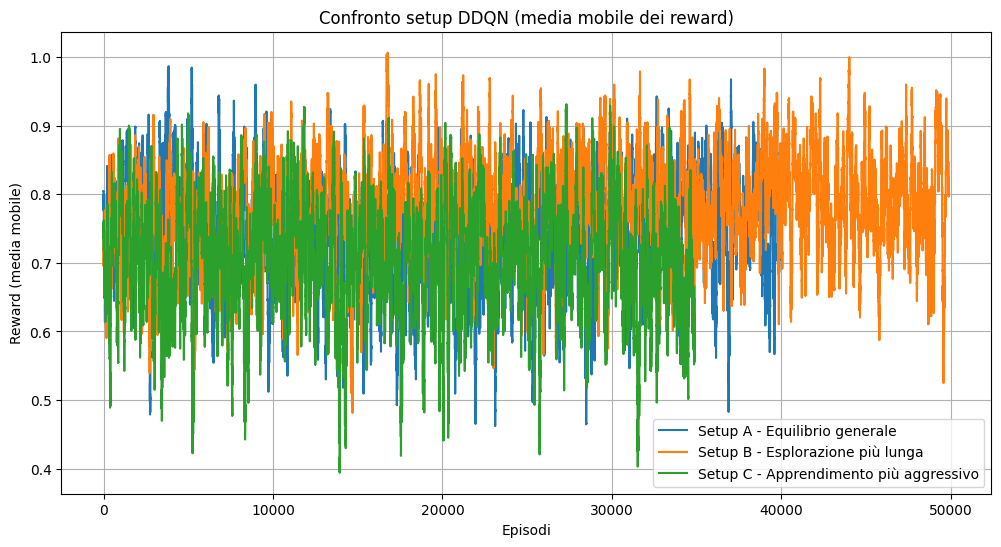

In [ ]:

plt.figure(figsize=(12,6))
for name, rewards, _ in results:
    ma = moving_average(rewards, 100)
    plt.plot(ma, label=name)

plt.title("Confronto setup DDQN (media mobile dei reward)")
plt.xlabel("Episodi")
plt.ylabel("Reward (media mobile)")
plt.legend()
plt.grid()
plt.show()


**PERFORMANCE**: *RANDOM ATTACK*

*Setup A: Equilibrio generale*
Decay moderato di epsilon (0.992) con valore minimo molto basso (0.01). Learning rate medio (3e-4) e buffer di dimensione contenuta. L’agente bilancia bene esplorazione e sfruttamento, valorizzando le ricompense future con gamma alto (0.985). Il conclusione presenta un apprendimento stabile e progressivo con buona capacità di generalizzazione.

*Setup B: Esplorazione prolungata*
Decay lento di epsilon (0.995) ma epsilon minimo più alto (0.05), favorendo una maggiore esplorazione anche in fasi avanzate. Learning rate basso (1e-4) e buffer ampio per mantenere esperienze recenti. Gamma molto alto (0.99) per dare peso alle ricompense future. Performance attese: apprendimento più conservativo e stabile, con minor rischio di convergenza su politiche sub-ottimali.

*Setup C: Apprendimento aggressivo*
Decay veloce di epsilon (0.985) con epsilon minimo basso (0.01), batch size grande (128) e learning rate alto (5e-4). L’agente sfrutta più rapidamente la politica appresa, ma con più variabilità nella ricompensa. Gamma leggermente inferiore (0.98) per preferire ricompense più immediate. In questo setup si ha un apprendimento rapido ma più “rumoroso” e meno stabile, ideale per scenari in cui serve convergenza veloce.



In [ ]:



def policy(state, q_net):
        q_net.eval()
        state_proc = preprocess_state(state)
        state_tensor = torch.FloatTensor(state_proc).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = q_net(state_tensor)
            return torch.argmax(q_values).item()

def evaluate_policy_ddqn(env, policy, attacker, q_net, num_episodes=100, run_test=5, seed=42, reward_shaping=True):
    def shape_reward(r):
        # Se il reward è una tupla, usiamo il reward del difensore (indice 1)
        raw_reward = r[1] if isinstance(r, tuple) else r
        if not reward_shaping:
            return raw_reward


        # Esempio semplice di shaping
         # Reward shaping moderato
        if raw_reward > 0:
            # Mantieni o aumenta leggermente le ricompense positive
            return raw_reward + 0.1
        elif raw_reward < 0:
            # Penalizza le ricompense negative ma in modo soft
            return raw_reward - 0.1
        else:
            # Per gli zero, assegna una piccola penalità per incoraggiare azioni più efficaci
            return -0.02

    total_rewards = []

    for run in range(run_test):
        for episode in range(num_episodes):
            state = env.reset(seed + run * num_episodes + episode)
            if isinstance(state, tuple):
                state = state[0]

            done = False
            total_reward = 0

            while not done:
                state_key = state_to_key(state)

                # --- Selezione azione difensore ---
                if policy == "random":
                    action_def = env.defender_action_space.sample()
                elif policy == "null":
                    action_def = 0
                elif callable(policy):
                    # DDQN policy come funzione
                    action_def = policy(state,q_net)
                else:
                    # Tabella di Q (dict)
                    action_def = policy.get(state_key, env.defender_action_space.sample())

                # Azione attaccante
                action_att = attacker.sample()

                # Interazione ambiente
                next_state, reward, done, _ = env.step((action_att, action_def))
                if isinstance(next_state, tuple):
                    next_state = next_state[0]

                # Reward shaping
                shaped_reward = shape_reward(reward)
                total_reward += shaped_reward

                state = next_state

            total_rewards.append(total_reward)

    avg_reward = sum(total_rewards) / (num_episodes * run_test)
    return round(avg_reward, 2)



num_test_episodes = 300
mode_attacker = {
    'random': 'random',
    'deterministico': 'deterministic',
    'ciclico': 'cyclic'
}
env = random_attack()
for name, rewards, q_net in results:
    # utilizziamo q_net per recuperare la policy appresa

    print(f"\nValutazione difensore DDQN: {name}")
    for mode_name, mode_val in mode_attacker.items():
        attacker = AttackerAgent(env.attacker_action_space, mode=mode_val, fixed_action=0)
        print(f" - Attaccante {mode_name}:")
        val_def = evaluate_policy_ddqn(env, policy, attacker, q_net, num_test_episodes, seed=42 )
        val_def_random = evaluate_policy_ddqn(env, "random", attacker, q_net, num_test_episodes, seed=42)
        val_def_null = evaluate_policy_ddqn(env, "null", attacker,q_net, num_test_episodes, seed=42)
        print(f"   Difensore DDQN policy: {val_def}")
        print(f"   Difensore random policy: {val_def_random}")
        print(f"   Difensore null policy: {val_def_null}")



Valutazione difensore DDQN: Setup A - Equilibrio generale
 - Attaccante random:
   Difensore DDQN policy: 0.88
   Difensore random policy: 0.72
   Difensore null policy: 0.66
 - Attaccante deterministico:
   Difensore DDQN policy: 0.85
   Difensore random policy: 0.74
   Difensore null policy: 0.65
 - Attaccante ciclico:
   Difensore DDQN policy: 0.86
   Difensore random policy: 0.72
   Difensore null policy: 0.61

Valutazione difensore DDQN: Setup B - Esplorazione più lunga
 - Attaccante random:
   Difensore DDQN policy: 0.7
   Difensore random policy: 0.74
   Difensore null policy: 0.63
 - Attaccante deterministico:
   Difensore DDQN policy: 0.71
   Difensore random policy: 0.78
   Difensore null policy: 0.59
 - Attaccante ciclico:
   Difensore DDQN policy: 0.72
   Difensore random policy: 0.75
   Difensore null policy: 0.62

Valutazione difensore DDQN: Setup C - Apprendimento più aggressivo
 - Attaccante random:
   Difensore DDQN policy: 0.67
   Difensore random policy: 0.75
   Dif

Il reward shaping migliora la strategia random fornendo segnali di ricompensa più informativi e guidati, che evidenziano azioni vantaggiose o da evitare. Questo aiuta l’agente a imparare più rapidamente e a prendere decisioni migliori, trasformando una ricompensa grezza e sporadica in un feedback più denso e strutturato, superando così la casualità della strategia random.

**ANALISI RISULTATI**: *RANDOM ATTACK*

Guardando i risultati dei tre setup di training, emerge subito che il primo setup (Setup A - Equilibrio generale) è quello che ha dato i risultati migliori. La rete difensiva, dopo l’allenamento, riesce a fare molto meglio sia della strategia casuale (random) che di quella fissa (null). Questo significa che il modello ha effettivamente imparato a riconoscere situazioni e a scegliere azioni più efficaci per difendersi dagli attacchi. In pratica, il difensore “intelligente” è in grado di ridurre i danni o ottenere risultati migliori rispetto a un difensore che agisce a caso o che non fa praticamente nulla.

Passando invece agli altri due setup, i risultati sono un po’ meno soddisfacenti. Nel Setup B (Esplorazione più lunga), la rete non sembra aver imparato molto bene: la sua performance è addirittura inferiore rispetto alla strategia casuale. Questo potrebbe accadere perché, mantenendo un livello alto di esplorazione per troppo tempo, il modello non riesce a “fissare” una strategia valida. È come se fosse ancora indeciso, prova troppe azioni a caso e quindi non migliora veramente.

Nel Setup C (Apprendimento più aggressivo), la situazione non migliora molto. Qui la rete ha un tasso di apprendimento più alto e batch più grandi, ma sembra che questo approccio abbia creato instabilità. Il modello probabilmente “salta” troppo velocemente tra strategie diverse, senza consolidarne una buona. Di nuovo, la performance è inferiore a quella di un difensore che agisce a caso. In altre parole, l’apprendimento è stato troppo rapido e poco stabile per portare a buoni risultati.
In conclusione, questi risultati evidenziano quanto sia fondamentale bilanciare attentamente il processo di apprendimento: evitare di essere troppo conservativi, come nel Setup B con un’esplorazione prolungata, ma anche di non esagerare con un approccio troppo veloce o intenso, come nel Setup C con un tasso di apprendimento elevato.


Avvio training con: Setup 1 - Decay molto lento, lr stabile


  0%|          | 28/50000 [00:00<03:14, 257.32it/s]

Episode 0 | AvgReward: 1.08 | Epsilon: 0.997


  2%|▏         | 1016/50000 [00:14<11:06, 73.51it/s]

Episode 1000 | AvgReward: 0.68 | Epsilon: 0.050


  4%|▍         | 2003/50000 [00:29<11:07, 71.86it/s]

Episode 2000 | AvgReward: 0.91 | Epsilon: 0.050


  6%|▌         | 3013/50000 [00:46<12:25, 63.04it/s]

Episode 3000 | AvgReward: 0.89 | Epsilon: 0.050


  8%|▊         | 4012/50000 [01:03<11:32, 66.37it/s]

Episode 4000 | AvgReward: 0.88 | Epsilon: 0.050


 10%|█         | 5012/50000 [01:19<10:12, 73.40it/s]

Episode 5000 | AvgReward: 0.90 | Epsilon: 0.050


 12%|█▏        | 6012/50000 [01:35<12:32, 58.47it/s]

Episode 6000 | AvgReward: 0.90 | Epsilon: 0.050


 14%|█▍        | 7009/50000 [01:52<12:06, 59.17it/s]

Episode 7000 | AvgReward: 0.86 | Epsilon: 0.050


 16%|█▌        | 8006/50000 [02:07<11:02, 63.43it/s]

Episode 8000 | AvgReward: 0.91 | Epsilon: 0.050


 18%|█▊        | 9008/50000 [02:24<09:04, 75.22it/s]

Episode 9000 | AvgReward: 0.90 | Epsilon: 0.050


 20%|██        | 10007/50000 [02:41<11:08, 59.82it/s]

Episode 10000 | AvgReward: 0.89 | Epsilon: 0.050


 22%|██▏       | 11008/50000 [02:59<11:59, 54.17it/s]

Episode 11000 | AvgReward: 0.91 | Epsilon: 0.050


 24%|██▍       | 12011/50000 [03:15<11:30, 55.05it/s]

Episode 12000 | AvgReward: 0.91 | Epsilon: 0.050


 26%|██▌       | 13008/50000 [03:32<11:01, 55.95it/s]

Episode 13000 | AvgReward: 0.92 | Epsilon: 0.050


 28%|██▊       | 14011/50000 [03:49<10:19, 58.09it/s]

Episode 14000 | AvgReward: 0.93 | Epsilon: 0.050


 30%|███       | 15006/50000 [04:05<08:16, 70.44it/s]

Episode 15000 | AvgReward: 0.92 | Epsilon: 0.050


 32%|███▏      | 16009/50000 [04:22<08:18, 68.19it/s]

Episode 16000 | AvgReward: 0.96 | Epsilon: 0.050


 34%|███▍      | 17011/50000 [04:39<08:53, 61.78it/s]

Episode 17000 | AvgReward: 0.90 | Epsilon: 0.050


 36%|███▌      | 18015/50000 [04:56<07:19, 72.76it/s]

Episode 18000 | AvgReward: 0.92 | Epsilon: 0.050


 38%|███▊      | 19010/50000 [05:14<12:56, 39.93it/s]

Episode 19000 | AvgReward: 0.88 | Epsilon: 0.050


 40%|████      | 20013/50000 [05:31<09:13, 54.20it/s]

Episode 20000 | AvgReward: 0.93 | Epsilon: 0.050


 42%|████▏     | 21010/50000 [05:48<07:10, 67.39it/s]

Episode 21000 | AvgReward: 0.92 | Epsilon: 0.050


 44%|████▍     | 22014/50000 [06:06<06:28, 72.08it/s]

Episode 22000 | AvgReward: 0.89 | Epsilon: 0.050


 46%|████▌     | 23008/50000 [06:23<06:51, 65.53it/s]

Episode 23000 | AvgReward: 0.95 | Epsilon: 0.050


 48%|████▊     | 24007/50000 [06:40<08:40, 49.98it/s]

Episode 24000 | AvgReward: 0.95 | Epsilon: 0.050


 50%|█████     | 25008/50000 [06:57<07:50, 53.11it/s]

Episode 25000 | AvgReward: 0.95 | Epsilon: 0.050


 52%|█████▏    | 26008/50000 [07:14<07:15, 55.14it/s]

Episode 26000 | AvgReward: 0.87 | Epsilon: 0.050


 54%|█████▍    | 27012/50000 [07:32<07:15, 52.78it/s]

Episode 27000 | AvgReward: 0.96 | Epsilon: 0.050


 56%|█████▌    | 28010/50000 [07:49<05:43, 64.09it/s]

Episode 28000 | AvgReward: 0.90 | Epsilon: 0.050


 58%|█████▊    | 29006/50000 [08:07<06:59, 50.07it/s]

Episode 29000 | AvgReward: 0.92 | Epsilon: 0.050


 60%|██████    | 30010/50000 [08:24<05:06, 65.31it/s]

Episode 30000 | AvgReward: 0.92 | Epsilon: 0.050


 62%|██████▏   | 31010/50000 [08:42<04:56, 64.00it/s]

Episode 31000 | AvgReward: 0.89 | Epsilon: 0.050


 64%|██████▍   | 32009/50000 [08:58<06:09, 48.65it/s]

Episode 32000 | AvgReward: 0.95 | Epsilon: 0.050


 66%|██████▌   | 33006/50000 [09:16<04:51, 58.29it/s]

Episode 33000 | AvgReward: 0.91 | Epsilon: 0.050


 68%|██████▊   | 34008/50000 [09:33<03:20, 79.71it/s]

Episode 34000 | AvgReward: 0.90 | Epsilon: 0.050


 70%|███████   | 35015/50000 [09:50<03:43, 67.11it/s]

Episode 35000 | AvgReward: 0.88 | Epsilon: 0.050


 72%|███████▏  | 36009/50000 [10:08<05:08, 45.32it/s]

Episode 36000 | AvgReward: 0.92 | Epsilon: 0.050


 74%|███████▍  | 37008/50000 [10:24<03:09, 68.70it/s]

Episode 37000 | AvgReward: 0.91 | Epsilon: 0.050


 76%|███████▌  | 38007/50000 [10:42<02:53, 69.05it/s]

Episode 38000 | AvgReward: 0.92 | Epsilon: 0.050


 78%|███████▊  | 39007/50000 [10:58<03:11, 57.43it/s]

Episode 39000 | AvgReward: 0.93 | Epsilon: 0.050


 80%|████████  | 40011/50000 [11:16<02:45, 60.18it/s]

Episode 40000 | AvgReward: 0.95 | Epsilon: 0.050


 82%|████████▏ | 41005/50000 [11:33<03:38, 41.22it/s]

Episode 41000 | AvgReward: 0.94 | Epsilon: 0.050


 84%|████████▍ | 42009/50000 [11:50<02:12, 60.43it/s]

Episode 42000 | AvgReward: 0.94 | Epsilon: 0.050


 86%|████████▌ | 43008/50000 [12:07<01:44, 66.77it/s]

Episode 43000 | AvgReward: 0.94 | Epsilon: 0.050


 88%|████████▊ | 44007/50000 [12:25<01:59, 49.98it/s]

Episode 44000 | AvgReward: 0.88 | Epsilon: 0.050


 90%|█████████ | 45011/50000 [12:42<01:08, 72.31it/s]

Episode 45000 | AvgReward: 0.92 | Epsilon: 0.050


 92%|█████████▏| 46015/50000 [13:01<00:48, 81.86it/s]

Episode 46000 | AvgReward: 0.86 | Epsilon: 0.050


 94%|█████████▍| 47004/50000 [13:18<00:46, 63.84it/s]

Episode 47000 | AvgReward: 0.92 | Epsilon: 0.050


 96%|█████████▌| 48008/50000 [13:36<00:36, 53.98it/s]

Episode 48000 | AvgReward: 0.89 | Epsilon: 0.050


 98%|█████████▊| 49012/50000 [13:54<00:17, 58.09it/s]

Episode 49000 | AvgReward: 0.91 | Epsilon: 0.050


100%|██████████| 50000/50000 [14:11<00:00, 58.71it/s]



Avvio training con: Setup 2 - Decay bilanciato, lr moderato


  0%|          | 19/40000 [00:00<03:33, 187.54it/s]

Episode 0 | AvgReward: 1.04 | Epsilon: 0.995


  3%|▎         | 1007/40000 [00:15<11:04, 58.69it/s]

Episode 1000 | AvgReward: 0.70 | Epsilon: 0.010


  5%|▌         | 2007/40000 [00:32<11:40, 54.21it/s]

Episode 2000 | AvgReward: 0.93 | Epsilon: 0.010


  8%|▊         | 3009/40000 [00:48<12:48, 48.15it/s]

Episode 3000 | AvgReward: 0.97 | Epsilon: 0.010


 10%|█         | 4010/40000 [01:07<08:16, 72.51it/s]

Episode 4000 | AvgReward: 0.94 | Epsilon: 0.010


 13%|█▎        | 5007/40000 [01:24<09:58, 58.43it/s]

Episode 5000 | AvgReward: 0.98 | Epsilon: 0.010


 15%|█▌        | 6012/40000 [01:42<10:48, 52.43it/s]

Episode 6000 | AvgReward: 0.93 | Epsilon: 0.010


 18%|█▊        | 7017/40000 [02:00<08:25, 65.31it/s]

Episode 7000 | AvgReward: 0.94 | Epsilon: 0.010


 20%|██        | 8012/40000 [02:20<09:59, 53.33it/s]

Episode 8000 | AvgReward: 0.93 | Epsilon: 0.010


 23%|██▎       | 9007/40000 [02:39<13:06, 39.40it/s]

Episode 9000 | AvgReward: 0.92 | Epsilon: 0.010


 25%|██▌       | 10010/40000 [02:58<09:33, 52.26it/s]

Episode 10000 | AvgReward: 0.90 | Epsilon: 0.010


 28%|██▊       | 11004/40000 [03:17<09:28, 51.00it/s]

Episode 11000 | AvgReward: 0.89 | Epsilon: 0.010


 30%|███       | 12007/40000 [03:36<09:26, 49.39it/s]

Episode 12000 | AvgReward: 0.94 | Epsilon: 0.010


 33%|███▎      | 13011/40000 [03:55<09:05, 49.50it/s]

Episode 13000 | AvgReward: 0.87 | Epsilon: 0.010


 35%|███▌      | 14007/40000 [04:13<07:02, 61.55it/s]

Episode 14000 | AvgReward: 0.90 | Epsilon: 0.010


 38%|███▊      | 15013/40000 [04:33<07:56, 52.44it/s]

Episode 15000 | AvgReward: 0.93 | Epsilon: 0.010


 40%|████      | 16015/40000 [04:52<06:29, 61.62it/s]

Episode 16000 | AvgReward: 0.92 | Epsilon: 0.010


 43%|████▎     | 17009/40000 [05:11<06:46, 56.52it/s]

Episode 17000 | AvgReward: 0.94 | Epsilon: 0.010


 45%|████▌     | 18008/40000 [05:31<08:37, 42.49it/s]

Episode 18000 | AvgReward: 0.94 | Epsilon: 0.010


 48%|████▊     | 19007/40000 [05:51<07:34, 46.18it/s]

Episode 19000 | AvgReward: 0.93 | Epsilon: 0.010


 50%|█████     | 20004/40000 [06:11<06:16, 53.11it/s]

Episode 20000 | AvgReward: 0.93 | Epsilon: 0.010


 53%|█████▎    | 21004/40000 [06:30<09:09, 34.56it/s]

Episode 21000 | AvgReward: 0.91 | Epsilon: 0.010


 55%|█████▌    | 22008/40000 [06:50<06:44, 44.48it/s]

Episode 22000 | AvgReward: 0.98 | Epsilon: 0.010


 58%|█████▊    | 23010/40000 [07:10<05:33, 50.87it/s]

Episode 23000 | AvgReward: 0.91 | Epsilon: 0.010


 60%|██████    | 24006/40000 [07:30<05:13, 50.94it/s]

Episode 24000 | AvgReward: 0.96 | Epsilon: 0.010


 63%|██████▎   | 25010/40000 [07:50<05:05, 49.12it/s]

Episode 25000 | AvgReward: 0.98 | Epsilon: 0.010


 65%|██████▌   | 26014/40000 [08:11<03:07, 74.72it/s]

Episode 26000 | AvgReward: 0.94 | Epsilon: 0.010


 68%|██████▊   | 27012/40000 [08:31<03:15, 66.47it/s]

Episode 27000 | AvgReward: 0.97 | Epsilon: 0.010


 70%|███████   | 28007/40000 [08:49<03:39, 54.71it/s]

Episode 28000 | AvgReward: 0.99 | Epsilon: 0.010


 73%|███████▎  | 29006/40000 [09:08<02:51, 64.07it/s]

Episode 29000 | AvgReward: 0.97 | Epsilon: 0.010


 75%|███████▌  | 30005/40000 [09:28<02:41, 61.92it/s]

Episode 30000 | AvgReward: 0.97 | Epsilon: 0.010


 78%|███████▊  | 31006/40000 [09:48<02:37, 57.06it/s]

Episode 31000 | AvgReward: 0.99 | Epsilon: 0.010


 80%|████████  | 32010/40000 [10:07<02:19, 57.31it/s]

Episode 32000 | AvgReward: 0.96 | Epsilon: 0.010


 83%|████████▎ | 33010/40000 [10:27<01:51, 62.61it/s]

Episode 33000 | AvgReward: 0.92 | Epsilon: 0.010


 85%|████████▌ | 34005/40000 [10:45<01:40, 59.62it/s]

Episode 34000 | AvgReward: 0.88 | Epsilon: 0.010


 88%|████████▊ | 35008/40000 [11:05<01:37, 51.28it/s]

Episode 35000 | AvgReward: 0.93 | Epsilon: 0.010


 90%|█████████ | 36006/40000 [11:24<01:16, 51.96it/s]

Episode 36000 | AvgReward: 0.95 | Epsilon: 0.010


 93%|█████████▎| 37015/40000 [11:43<00:43, 68.04it/s]

Episode 37000 | AvgReward: 0.79 | Epsilon: 0.010


 95%|█████████▌| 38006/40000 [12:01<00:35, 55.43it/s]

Episode 38000 | AvgReward: 0.89 | Epsilon: 0.010


 98%|█████████▊| 39009/40000 [12:19<00:18, 52.85it/s]

Episode 39000 | AvgReward: 0.86 | Epsilon: 0.010


100%|██████████| 40000/40000 [12:38<00:00, 52.74it/s]



Avvio training con: Setup 3 - Decay veloce, batch più grande, lr alto


  0%|          | 45/30000 [00:00<01:08, 437.32it/s]

Episode 0 | AvgReward: -1.16 | Epsilon: 0.980


  3%|▎         | 1013/30000 [00:15<07:21, 65.72it/s]

Episode 1000 | AvgReward: 0.57 | Epsilon: 0.100


  7%|▋         | 2009/30000 [00:30<06:47, 68.65it/s]

Episode 2000 | AvgReward: 0.54 | Epsilon: 0.100


 10%|█         | 3006/30000 [00:46<08:12, 54.84it/s]

Episode 3000 | AvgReward: 0.49 | Epsilon: 0.100


 13%|█▎        | 4010/30000 [01:03<06:54, 62.75it/s]

Episode 4000 | AvgReward: 0.50 | Epsilon: 0.100


 17%|█▋        | 5013/30000 [01:19<06:55, 60.14it/s]

Episode 5000 | AvgReward: 0.47 | Epsilon: 0.100


 20%|██        | 6006/30000 [01:36<06:45, 59.21it/s]

Episode 6000 | AvgReward: 0.62 | Epsilon: 0.100


 23%|██▎       | 7007/30000 [01:54<06:10, 62.08it/s]

Episode 7000 | AvgReward: 0.57 | Epsilon: 0.100


 27%|██▋       | 8008/30000 [02:11<05:55, 61.89it/s]

Episode 8000 | AvgReward: 0.62 | Epsilon: 0.100


 30%|███       | 9011/30000 [02:28<06:09, 56.80it/s]

Episode 9000 | AvgReward: 0.61 | Epsilon: 0.100


 33%|███▎      | 10009/30000 [02:46<09:57, 33.45it/s]

Episode 10000 | AvgReward: 0.64 | Epsilon: 0.100


 37%|███▋      | 11012/30000 [03:04<05:56, 53.19it/s]

Episode 11000 | AvgReward: 0.56 | Epsilon: 0.100


 40%|████      | 12008/30000 [03:21<05:11, 57.70it/s]

Episode 12000 | AvgReward: 0.60 | Epsilon: 0.100


 43%|████▎     | 13006/30000 [03:40<04:43, 59.94it/s]

Episode 13000 | AvgReward: 0.58 | Epsilon: 0.100


 47%|████▋     | 14016/30000 [03:57<04:12, 63.20it/s]

Episode 14000 | AvgReward: 0.60 | Epsilon: 0.100


 50%|█████     | 15008/30000 [04:16<05:32, 45.12it/s]

Episode 15000 | AvgReward: 0.63 | Epsilon: 0.100


 53%|█████▎    | 16011/30000 [04:33<03:45, 61.97it/s]

Episode 16000 | AvgReward: 0.58 | Epsilon: 0.100


 57%|█████▋    | 17010/30000 [04:51<03:58, 54.37it/s]

Episode 17000 | AvgReward: 0.55 | Epsilon: 0.100


 60%|██████    | 18006/30000 [05:08<04:05, 48.87it/s]

Episode 18000 | AvgReward: 0.59 | Epsilon: 0.100


 63%|██████▎   | 19009/30000 [05:26<03:01, 60.64it/s]

Episode 19000 | AvgReward: 0.58 | Epsilon: 0.100


 67%|██████▋   | 20011/30000 [05:44<02:33, 65.11it/s]

Episode 20000 | AvgReward: 0.68 | Epsilon: 0.100


 70%|███████   | 21004/30000 [06:02<02:05, 71.61it/s]

Episode 21000 | AvgReward: 0.60 | Epsilon: 0.100


 73%|███████▎  | 22009/30000 [06:20<01:51, 71.36it/s]

Episode 22000 | AvgReward: 0.62 | Epsilon: 0.100


 77%|███████▋  | 23013/30000 [06:39<01:28, 78.68it/s]

Episode 23000 | AvgReward: 0.60 | Epsilon: 0.100


 80%|████████  | 24008/30000 [06:58<01:41, 59.03it/s]

Episode 24000 | AvgReward: 0.57 | Epsilon: 0.100


 83%|████████▎ | 25005/30000 [07:17<02:05, 39.90it/s]

Episode 25000 | AvgReward: 0.53 | Epsilon: 0.100


 87%|████████▋ | 26013/30000 [07:35<01:14, 53.59it/s]

Episode 26000 | AvgReward: 0.61 | Epsilon: 0.100


 90%|█████████ | 27011/30000 [07:53<00:52, 56.84it/s]

Episode 27000 | AvgReward: 0.63 | Epsilon: 0.100


 93%|█████████▎| 28006/30000 [08:12<00:55, 36.23it/s]

Episode 28000 | AvgReward: 0.64 | Epsilon: 0.100


 97%|█████████▋| 29004/30000 [08:29<00:15, 63.40it/s]

Episode 29000 | AvgReward: 0.67 | Epsilon: 0.100


100%|██████████| 30000/30000 [08:49<00:00, 56.70it/s]


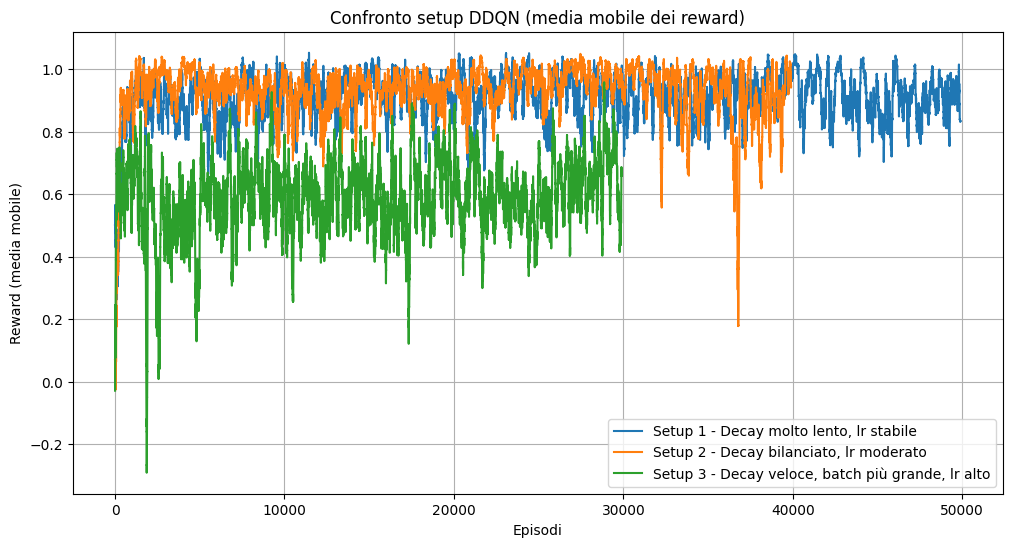

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_idsgame
from gym_idsgame.envs import IdsGameMaximalAttackV0Env as maximal_attack
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Setup
setups = [
    {
        "name": "Setup 1 - Decay molto lento, lr stabile",
        "epsilon": 1.0,
        "epsilon_min": 0.05,
        "epsilon_decay": 0.997,
        "gamma": 0.99,
        "batch_size": 64,
        "buffer_maxlen": 100000,
        "update_target_every": 20,
        "num_episodes": 50000,
        "lr": 1e-4
    },
    {
        "name": "Setup 2 - Decay bilanciato, lr moderato",
        "epsilon": 1.0,
        "epsilon_min": 0.01,
        "epsilon_decay": 0.995,
        "gamma": 0.98,
        "batch_size": 64,
        "buffer_maxlen": 100000,
        "update_target_every": 10,
        "num_episodes": 40000,
        "lr": 5e-4
    },
    {
        "name": "Setup 3 - Decay veloce, batch più grande, lr alto",
        "epsilon": 1.0,
        "epsilon_min": 0.1,
        "epsilon_decay": 0.98,
        "gamma": 0.95,
        "batch_size": 128,
        "buffer_maxlen": 50000,
        "update_target_every": 5,
        "num_episodes": 30000,
        "lr": 1e-3
    }
]

results = []

for setup in setups:
    print(f"\nAvvio training con: {setup['name']}")
    env = maximal_attack()

    sample_state = env.reset()
    if isinstance(sample_state, tuple):
        sample_state = sample_state[0]
    state_size = len(np.array(sample_state).flatten())
    action_size = env.defender_action_space.n

    q_network = DQN(state_size, action_size).to(device)
    target_network = DQN(state_size, action_size).to(device)
    target_network.load_state_dict(q_network.state_dict())

    optimizer = torch.optim.Adam(q_network.parameters(), lr=setup["lr"])
    criterion = torch.nn.MSELoss()

    q_net_trained, rewards = ddqn_learning(
        env=env,
        q_network=q_network,
        target_network=target_network,
        optimizer=optimizer,
        criterion=criterion,
        buffer_maxlen=setup["buffer_maxlen"],
        batch_size=setup["batch_size"],
        gamma=setup["gamma"],
        epsilon=setup["epsilon"],
        epsilon_min=setup["epsilon_min"],
        epsilon_decay=setup["epsilon_decay"],
        update_target_every=setup["update_target_every"],
        num_episodes=setup["num_episodes"],
        print_every=1000
    )

    results.append((setup["name"], rewards, q_net_trained))
    env.close()


plt.figure(figsize=(12,6))
for name, rewards, _ in results:
    ma = moving_average(rewards, 100)
    plt.plot(ma, label=name)

plt.title("Confronto setup DDQN (media mobile dei reward)")
plt.xlabel("Episodi")
plt.ylabel("Reward (media mobile)")
plt.legend()
plt.grid()
plt.show()


**PERFORMANCE**: *MAXIMAL ATTACK*

Rispetto a questi approcci di random attack, il concetto di maximal_attack rappresenta una strategia più mirata e deterministica. Invece di scegliere azioni casuali o quasi casuali come nel random attack, maximal_attack tende a scegliere sistematicamente l’azione con l’impatto più grande o “massimale” rispetto a un certo criterio (ad esempio, quella che produce il danno massimo o la perturbazione più significativa). Questo approccio può portare a risultati più rapidi o più efficaci in contesti dove si cerca di massimizzare un certo tipo di risultato, ma rischia anche di ridurre la diversità delle azioni esplorate.

In termini di apprendimento, l’attacco maximal_attack potrebbe ridurre la necessità di una lunga fase di esplorazione perché punta sempre all’azione considerata migliore, potenzialmente accelerando la convergenza, ma con il rischio di cadere in ottimi locali o politiche sub-ottimali se non calibrato bene. Al contrario, i setup di random attack, soprattutto quelli con decay più lento di epsilon, favoriscono una maggiore esplorazione, preservando la capacità del modello di scoprire strategie difensive diverse.

In questo contesto, i tre setup proposti per l’allenamento della rete neurale difensiva riflettono differenti scelte di bilanciamento tra esplorazione e sfruttamento, ognuno con punti di forza e limiti.

Il Setup 1 si caratterizza per un decadimento molto lento di epsilon, mantenendo quindi una lunga fase di esplorazione. Ciò permette all’agente difensivo di provare molte azioni diverse e apprendere con calma, grazie anche a un learning rate basso e stabile che favorisce aggiornamenti graduali. Questa configurazione è particolarmente utile in scenari complessi dove è importante evitare di convergere troppo presto su strategie sub-ottimali.

Il Setup 2 presenta un decadimento di epsilon più bilanciato, che consente una transizione più rapida dall’esplorazione allo sfruttamento. Il learning rate moderato e il valore minimo di epsilon più basso aiutano a consolidare le strategie efficaci emerse durante il training, pur mantenendo una residuale capacità di esplorare. È un compromesso efficace per ambienti dove serve apprendere velocemente ma senza perdere flessibilità.

Infine, il Setup 3 privilegia una convergenza veloce grazie a un decadimento rapido di epsilon, un batch size più grande e un learning rate alto. L’agente riduce presto l’esplorazione e punta a sfruttare rapidamente le migliori azioni individuate, rischiando però di trascurare alternative potenzialmente migliori. Questa configurazione è indicata in situazioni in cui la rapidità nell’adottare una strategia difensiva efficace è prioritaria, anche a scapito di una minor generalizzazione.

In sintesi, mentre i setup tipici di random attack cercano un bilanciamento tra esplorazione e sfruttamento per affrontare scenari imprevedibili, l’attacco maximal_attack richiede al difensore di adattarsi a una minaccia più aggressiva e mirata. I diversi setup per la rete neurale difensiva riflettono proprio questa necessità di calibrare l’apprendimento tra esplorazione ampia e convergenza rapida, a seconda delle caratteristiche dell’ambiente e degli obiettivi di difesa.

In [ ]:


num_test_episodes = 300
mode_attacker = {
    'random': 'random',
    'deterministico': 'deterministic',
    'ciclico': 'cyclic'
}
env = maximal_attack()
for name, rewards, q_net in results:
    # utilizziamo q_net per recuperare la policy appresa
    # q_values = q_net(state)
    # return torch.argmax(q_values).item()

    print(f"\nValutazione difensore DDQN: {name}")
    for mode_name, mode_val in mode_attacker.items():
        attacker = AttackerAgent(env.attacker_action_space, mode=mode_val, fixed_action=0)
        print(f" - Attaccante {mode_name}:")
        val_def = evaluate_policy_ddqn(env, policy, attacker, q_net, num_test_episodes, seed=42 )
        val_def_random = evaluate_policy_ddqn(env, "random", attacker, q_net, num_test_episodes, seed=42)
        val_def_null = evaluate_policy_ddqn(env, "null", attacker,q_net, num_test_episodes, seed=42)
        print(f"   Difensore DDQN policy: {val_def}")
        print(f"   Difensore random policy: {val_def_random}")
        print(f"   Difensore null policy: {val_def_null}")



Valutazione difensore DDQN: Setup 1 - Decay molto lento, lr stabile
 - Attaccante random:
   Difensore DDQN policy: 1.04
   Difensore random policy: 0.24
   Difensore null policy: 0.91
 - Attaccante deterministico:
   Difensore DDQN policy: 1.04
   Difensore random policy: 0.23
   Difensore null policy: 0.94
 - Attaccante ciclico:
   Difensore DDQN policy: 1.04
   Difensore random policy: 0.23
   Difensore null policy: 0.93

Valutazione difensore DDQN: Setup 2 - Decay bilanciato, lr moderato
 - Attaccante random:
   Difensore DDQN policy: 0.94
   Difensore random policy: 0.24
   Difensore null policy: 0.93
 - Attaccante deterministico:
   Difensore DDQN policy: 0.97
   Difensore random policy: 0.24
   Difensore null policy: 0.91
 - Attaccante ciclico:
   Difensore DDQN policy: 0.94
   Difensore random policy: 0.22
   Difensore null policy: 0.92

Valutazione difensore DDQN: Setup 3 - Decay veloce, batch più grande, lr alto
 - Attaccante random:
   Difensore DDQN policy: 0.95
   Difenso

**ANALISI RISULTATI**: *MAXIMAL ATTACK*

Dai risultati emerge chiaramente che il difensore DDQN supera consistentemente sia la politica random sia quella null in tutti e tre i setup e contro tutte le tipologie di attacco (random, deterministico, ciclico).

Il Setup 1, con un decay molto lento di epsilon e learning rate basso, ottiene le migliori performance (reward attorno a 1.04), indicando che una lunga esplorazione favorisce l’apprendimento di strategie difensive più robuste e generalizzabili.

Il Setup 2, con un decay più bilanciato e learning rate moderato, raggiunge risultati leggermente inferiori (tra 0.94 e 0.97), ma mantiene comunque un buon vantaggio rispetto alle baseline, mostrando un buon compromesso tra esplorazione e velocità di apprendimento.

Il Setup 3, caratterizzato da un decay veloce, batch più grande e learning rate alto, non migliora ulteriormente le performance (reward intorno a 0.93-0.95), suggerendo che una riduzione troppo rapida dell’esplorazione può limitare la qualità della strategia appresa.

La random policy difensiva ottiene punteggi relativamente alti contro i vari attaccanti perché la sua imprevedibilità rende difficile per l’attaccante sfruttare sempre la stessa vulnerabilità. Questo dimostra che una certa casualità nelle difese può limitare l’efficacia di attacchi deterministici, anche se strategie più mirate restano fondamentali per prestazioni migliori.

In sintesi, i dati suggeriscono che anche in questo caso un’esplorazione più duratura risulta vantaggiosa per sviluppare difese efficaci contro attacchi maximal_attack mirati e deterministici.
